In [1]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import logomaker
import h5py

In [2]:
df = pd.read_csv('mpra_agarwal/0/preds.csv')
df.head()

,names,labels,preds
0,peak29573_Reversed:,0.079,-0.078764
1,ENSG00000123569,-0.523,-0.057243
2,peak68865,-0.128,-0.357935
3,LMO2_5265_Reversed:,-0.613,-0.580528
4,ENSG00000168811_Reversed:,-1.311,-0.913436


(-2.30285, 3.69985, -1.521112955, 1.603975055)

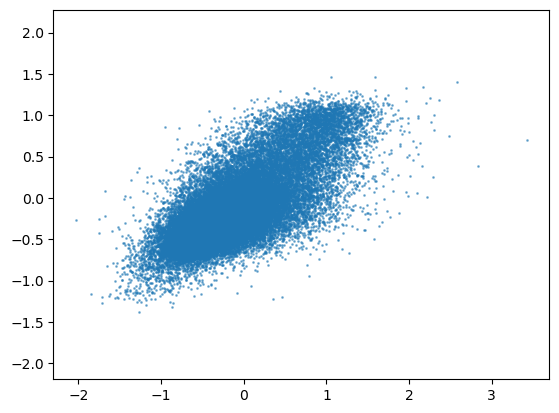

In [3]:
plt.scatter(df['labels'], df['preds'], s=1, alpha=0.5)
plt.axis('square')
plt.axis('equal')

## SSM

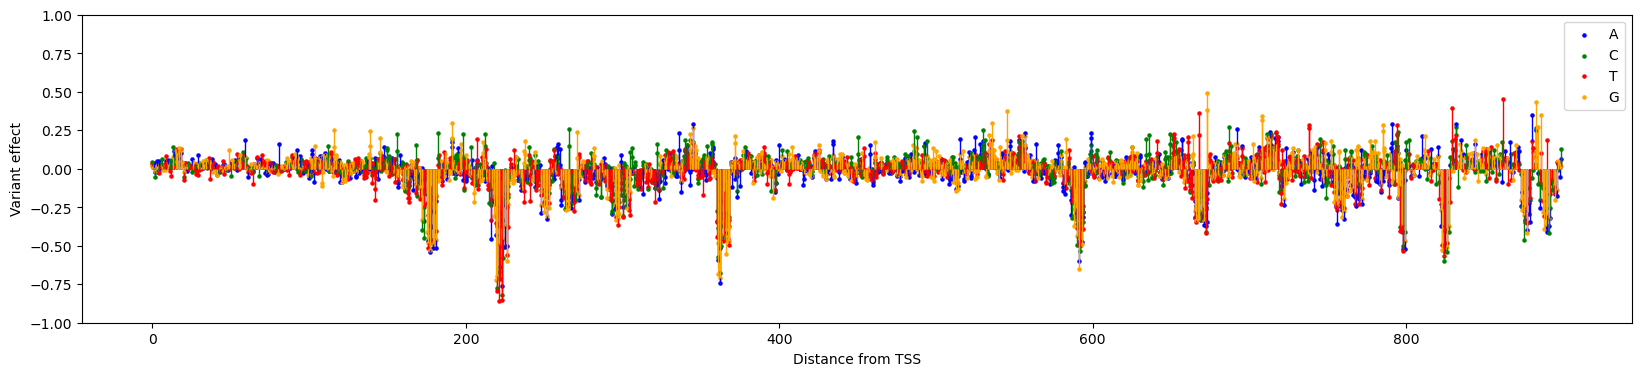

In [2]:
from analysis_utils import str_to_one_hot

pred_df = pd.read_csv('mpra_agarwal/apoa1_ssm/preds.csv')
source_data = pd.read_csv('../data/mpra_agarwal_seq/apoa1/val.csv')
#one_hot_seqs = np.stack([str_to_one_hot(s) for s in source_data['seq']])

# Assemble variant dataframe
variant_df = pred_df.copy()
name_split = variant_df['names'].str.split(':', expand=True)
variant_df['pos'] = name_split[0]
variant_df['var'] = name_split[1]
variant_df['frame'] = name_split[2]

# Save position and variant
variant_df['mutation'] = variant_df['pos'] + ':' + variant_df['var']

# Pull out non-variant sequences
original_rows = variant_df['names'].str.contains('original')
original_df = variant_df[original_rows]

variant_df = variant_df[~original_rows]

# Cast pos column as integer
variant_df['pos'] = variant_df['pos'].astype('int')

# Calculate change in score
for i, row in original_df.iterrows():
    frame = row[5]
    variant_df.loc[variant_df['frame'] == frame, 'baseline'] = row['preds']

variant_df['var_effect'] = variant_df['preds'] - variant_df['baseline']

# Group by mutation
mutation_map = variant_df[['mutation','pos','var']]
mean_effect = variant_df.groupby('mutation', as_index=False).mean(numeric_only=True)
mean_effect['var'] = mean_effect['mutation'].str.split(':', expand=True)[1]

# Pivot table to get values per variant
pivot_df = mean_effect.pivot(index='pos', columns='var', values='var_effect')
variant_effect = pivot_df.sum(axis=1)

# Plot variant effect
fig, ax = plt.subplots(figsize=(20,4))
colors = {'A':'blue', 'C':'green', 'T':'red', 'G':'orange'}

interval = 24

for l in ['A','C','T','G']:
    
    #select = variant_df[(variant_df['pos'] > 5550) & (variant_df['pos'] < 5650)]
    select = variant_df
    select_l = select[select['var'] == l]

    stem_plot = ax.stem(select_l['pos'], select_l['var_effect'], bottom=0, markerfmt=' ', basefmt=" ", linefmt=colors[l])
    ax.scatter(select_l['pos'], select_l['var_effect'], marker='o', s=5, color=colors[l])
    for stemline in stem_plot:
        stemline.set_linewidth(1)

ax.set_ylim(-1, 1)
ax.set_xlabel('Distance from TSS')
ax.set_ylabel('Variant effect')
ax.legend(colors)

(-0.75, 0.75)

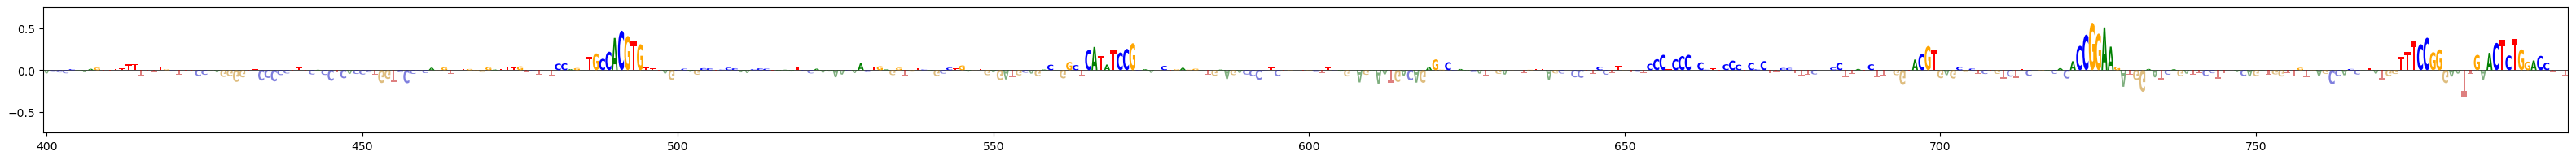

In [17]:
fig, ax = plt.subplots(figsize=(40,2))

# Group by mutation. Operate on select instead of entire pivot table
mutation_map = select[['mutation','pos','var']]
mean_effect = select.groupby('mutation', as_index=False).mean(numeric_only=True)
mean_effect['var'] = mean_effect['mutation'].str.split(':', expand=True)[1]

# Pivot table to get values per variant
pivot_df = mean_effect.pivot(index='pos', columns='var', values='var_effect')
variant_effect = pivot_df.sum(axis=1)

logo_df = pivot_df.applymap(lambda x: 0)

albumin_promoter = 'GCAACATTAATCTAAAAACCTCAATGACCCAAATAGAAAAGGAAAAAAGCTTTCTGAACAGCCAAACAGAGATTCCAAAGTTCAGGCACCAAAGTTCAGACCCTAACAGTTATTTACAAGGGTCAGTTAACCTTTTGTTCTAGTGGGATAGGATTCCCATGGTGAGATTTGAAGAACTGTGGAACCACTGTTTCAGGTTC'
albumin_enhancer = 'ATATATCAAAATAAACTTGAGGGGATAGATCATTTTCATGATATATGAGAAAAATTAAAAATCAGATTGAATTATTTGCCTGTCATACAGCTAATAATTGACCATAAGACAATTAGATTTAAATTAGTTTTGAATCTTTCTAATACCAAAGTTCAGTTTACTGTTCCATGTTGCTTCTGAGTGGCTTCACAGACTTATGAAAAAGTAAACGGAATCAGAATTACATCAATGCAAAAGCATTGCTGTGAACTCTGTACTTAGGACTAAACTTTGAGCAATAACACATATAGATTGAGGATTGTTTGCTGTTAGTATACAAACTCTGGTTCAAAGCTCCTCTTTATTGCTTGTCTTGGAAAATTTGCTGTTCTTCATGGTTTCTCTTTTCACTGCTATCTAT'
apo_mouse = 'ATTTGGACAGTGGAGCATCAACTGGGAGGCGCTATGGAGCCAGAGCCACCGAAGGCAGGTAGCAGCACTTACCTCCCCGGAGCTCTCCGACAGTCTGGGTGTCCAGCTCTTCTTCCCTGGTCTATATATGTGTGTGGGCAGGGGCTGGGCTGGGAGACTGATAAGCTCAGCCTGGCCCTGCCACTGCTTACTTTTGCTGGCGATGTGGAACTTAGAGTTCAAGGATCAGCTCTGTTCCTGAGGCTGGGCAAACAGAGTGGGCAAACAGGAAACTGCGGGGGCTGCCGAGCTGGGATCAAGGGTTCAGGTGGGGGCAGCAGGGGGTGGCTGCAGACTCCAGGGGTCCCCAGGGGTAAGGCAGTTGCACCATCCCGAGGTGTATGTCTTCTTCAAGATAGTCTCATGGAGCCCACTCCTGGACTCCTCTGTGTTGCTAGTGCCCTCTGAGCCTGGAACAAGGGAGGGAGGGAGGAATTGTGGGCTCCTTCACTCACAGCCCCACCCCAAAGTTTTTTTTTTGCTTTCCAAGGGGTTCCCCCTTTCACCTCACCCTGGTCCCCCAGGTTTGGGGATTTGTCTTTCCAGATGCCACATGTTTAGCCAGCCTCCCAACCCTAAATCCAAAAACAACTGAGGTGTCAGCCTGAGTGAGATGCAGACAGGCTCATATCCCCAAGCTGAGGATGAAGACCCCTCTGATGCTTCAGAAGAAATGACAGAGGCCAACATGGAGTTGTTAGCTCCTTCCTTGTCTCCCTCCCTCCTTCCCTCCCTTCCTTTCTTCCTTATCTTAGGTACATGAGCGCTCTGTCTTCAGACACACCAGAAGATGGAATCAGATTCCTTTACAGATGGTTGTGAGCCACCATATGGTTTCTGGGAATTGAACTCAGGACCTCT'
apo_human = 'AGGTACCCAGAGGCCCGGCCTGGGGCAAGGCCTGAACCTTGAGCTGGGGAGCCAGAGTGACCGGGGCAGGCAGCAGGACGCACCTCCTTCTCGCAGTCTCTAAGCAGCCAGCTCTTGCAGGGCCTATTTATGTCTGCAGCCAGGGTCTGGGCTGGGAGGCTGATAAGCCCAGCCCCGGCCCTGTTGCTGCTCACTGGTCCTGGCAATGTGGAACTTAAGAGTTCAAGGATCAGCTCTGTCCCTGGGGCTGGGCAAATAGAGTGGGCAAACAGCAAGCTGCGGGGGCTGCAGGGCAGGGGTCAAGGGTTCAGTGGGGGCGGGAGGGGAGTGTCTGCAGGCTTGCAGGTCTCCCGGGTGGGGTCGGGGTTCCCTGCACTCATCCCCTTCCCCTCCATGGGAGTGTGTGGGCAGTTGCCATTGTCCATTGTGTTGGCAGAGGAGGGGAGGGGAGGGACGCTGGGACTCCTCCACCAAGGAGACTGCCTCCCCCACCACCAGCATTCCAGGGAGACTACTTCACTCCCCTCCCCCTTCCCCCGCCCTGTCCTCCCACCAGTGCTCTTCTTTAGTCCCCAGCAGGTCCTCCAGGCCTCTCTCCAAGCCTCCCAAACTGGTAAACCTGGGGAGAGGGGAGAGCCCTCCGTGGCTCCCAGACTGAGGTTTCGGAGACCTCTTGCATTTCAAAACACTCCAGAGATCAATTCGGAGCTGCCAACTTTTAATTTTGTCATGTAAAGATATTGTCCGCCTCCAAAAAACCCTCACCATCTACAGTGACCATCACTTCAAAAAGGAAAGGCTTTAACAAAAAAGGGCATAATCTCAGAATTACATTACAGAATTGAAGCCCCTTAGATTGAAGACGTCTCCCTTTGCATTGTTCACACTTATATTTGATCA'

apo_mouse_optimized = 'ATTTGGACAGTGGAGCATCAACTGGGAGGCGCTATGGAGCCAGAGCCACCGAAGGCAGGTAGCAGCACTTACCTCCCCGGAGCTCTCCGACAGTCTGGGTGTCCAGCTCTTCTTCCCTGGTCTATATATGTGTGTGGGCAGGGGCTGGGCTGGGAGACTGATAAGCTCAGCCTGGCCCTCCCACTGCTTACTTTTGCTGGCGATGTGGAACTTAGAGTTCAAGGTTCAGCTCTGTTCCTGAGGCTGGGCAAACAGAGTGGGCAAACAGGAAACTGCGGGGGCTGCCGAGCTGGGATCAAGGGTTCAGGTGGGGGCAGCAGGGGGTGGCTGCAGACTCCAGGGGTCCCCAGGGGTAAGGCAGTTGCATCATCCCGAGGTGTATGTCTTCTTCAAGATAGTCTCATGGAGCCCACTCCTGGACTCCTCTGTGTTGCTAGTGCCCTCTGAGCCTGGAACAAGGGAGGGAGGGAGGAATTGTGGGCTCCTTCACTCACAGCCCCACCCCAAAGTTTTTTTTTTGCTTTCCAAGGGGTTCCCCCTTTCACCTCACCCTGGTCCCCCAGGTTTGGGGATTTGTCTTTCCAGATGCCACGTGTTTAGCCAGCCTCCCAACCCTAAATCCAAAAACAACTGAGGTGTCAGCCTGAGTGAGATGCAGACAGGCTCATATCCGCAAGCTGAGGATGAAGACCCCTCTGATGCTTCAGAAGAAATGACAGAGGCCAACATGGAGTTGTTAGCTCCTTCCTTGTCTCCCTCCCTCCTTCCCTCCCTTCCTTTCTTCCTTATCTTAGGTACGTGAGCGCTCTGTCTTCAGACACACCGGAAGATGGAATCAGATTCCTTTACAGATGGTTGTGAGCCACCATATGGTTTCCGGGAATTGAACTCTGGACCTCT'
apo_human_optimized = 'AGGTACCCAGAGGCCCGGCCTGGGGCAAGGCCTGAACCTTGAGCTGGGGAGCCAGAGTGACCGGGGCAGGCAGCAGGACGCACCTCCTTCTCGCAGTCTCTAAGCAGCCAGCTCTTGCAGGGCCTATTTATGTCTGCAGCCAGGGTCTGGGCTGGGAGGCTGATAAGCCCCGCCCCGGCCCTGTTGCTGCTCATTGGTCCTGGCAATGTGTAACTTCAGAGTTCAAGGTTCAGCTCTGTCCCTGGGGCTGGGCCAATAGAGTGGGCAAACAGGAAGCTGCGGGGGCTGCAGGGCAGGGGTCAAGGGTTCAGTGGGGGCGGGAGGGGAGTGTCTGCAGGCTTGCAGGTCTTCCGGGTGGGGTCGGGGTTCCCTGCACTCCTCCCCTTCCCCTCCATGGGAGTGTGTGGGCAGTTGCCATTGTCCATTGTGTTGGCAGAGGAGGGGAGGGGAGGGACGCTGGGACTCCTCCCCCAATGAGACTGCCTCCCCCACCACCAGCATTCCAGGGAGACTACGTCACTCCCCTCCCCCTTCCCCCGCCCTGTCCTCCCACCAGTGCTCTTCTTTAGTCCCCAGCAGGTCCTCCAGGCCTCTCTCCAAGCCTCCCAAACTGGTAAACCTGGGGAGAGGGGAGAGCCCTACGTGGCTCCCAGACTGAGGTTTCGGAGACCTCTTGCATTTCAAAACACTCCAGAGATCAATTCGGAGCTGCCAACTTTTAATTTTGTCATGTAAAGATATTGTCCGCCTCCAAAAAACCCTCACCATCTACAGTGACCATCACTTCAAAGAGGAAAGGCTTTAACAAAAAAGGGCATAATCTCAGAATTACATTACAGAATTGAAGCCCCTTAGATTGAAGACGTCTCCCTTTGCATTGTTCACACTTATATTTGATCA'

seq = apo_mouse_optimized

var_means = []
for i, row in pivot_df.iterrows():
    base = seq[int(i)]
    logo_df.loc[i, base] = row.mean()
    
# 100 base pairs from the TSS
logo_df.index = logo_df.index - 100
crp_logo = logomaker.Logo(-1*logo_df.iloc[500:1000],
                          shade_below=0.25,
                          fade_below=.5,
                          ax=ax)
ax.set_ylim([-0.75, 0.75])

In [18]:
new_seq = seq
for i, row in variant_df[variant_df['var_effect'] > 0.4].iterrows():
    pos = row['pos']
    var = row['var']
    print(pos,var)
    new_seq = new_seq[:pos] + var + new_seq[pos+1:]  # Correct way to 'modify' a string

new_seq

673 G
862 T
883 G


'ATTTGGACAGTGGAGCATCAACTGGGAGGCGCTATGGAGCCAGAGCCACCGAAGGCAGGTAGCAGCACTTACCTCCCCGGAGCTCTCCGACAGTCTGGGTGTCCAGCTCTTCTTCCCTGGTCTATATATGTGTGTGGGCAGGGGCTGGGCTGGGAGACTGATAAGCTCAGCCTGGCCCTCCCACTGCTTACTTTTGCTGGCGATGTGGAACTTAGAGTTCAAGGTTCAGCTCTGTTCCTGAGGCTGGGCAAACAGAGTGGGCAAACAGGAAACTGCGGGGGCTGCCGAGCTGGGATCAAGGGTTCAGGTGGGGGCAGCAGGGGGTGGCTGCAGACTCCAGGGGTCCCCAGGGGTAAGGCAGTTGCATCATCCCGAGGTGTATGTCTTCTTCAAGATAGTCTCATGGAGCCCACTCCTGGACTCCTCTGTGTTGCTAGTGCCCTCTGAGCCTGGAACAAGGGAGGGAGGGAGGAATTGTGGGCTCCTTCACTCACAGCCCCACCCCAAAGTTTTTTTTTTGCTTTCCAAGGGGTTCCCCCTTTCACCTCACCCTGGTCCCCCAGGTTTGGGGATTTGTCTTTCCAGATGCCACGTGTTTAGCCAGCCTCCCAACCCTAAATCCAAAAACAACTGAGGTGTCAGCCTGAGTGAGATGCAGACAGGCTCATATCCGGAAGCTGAGGATGAAGACCCCTCTGATGCTTCAGAAGAAATGACAGAGGCCAACATGGAGTTGTTAGCTCCTTCCTTGTCTCCCTCCCTCCTTCCCTCCCTTCCTTTCTTCCTTATCTTAGGTACGTGAGCGCTCTGTCTTCAGACACACCGGAAGATGGAATCAGATTCCTTTACAGATGGTTGTGAGTCACCATATGGTTTCCGGGAAGTGAACTCTGGACCTCT'

### Replace

In [16]:
from analysis_utils import str_to_one_hot

pred_df = pd.read_csv('mpra_agarwal/apoa1_ssm/preds.csv')
source_data = pd.read_csv('../data/mpra_agarwal_seq/apoa1/val.csv')

# Assemble variant dataframe
variant_df = pred_df.copy()
name_split = variant_df['names'].str.split(':', expand=True)
variant_df['pos'] = name_split[0]
variant_df['var'] = name_split[1]
variant_df['frame'] = name_split[2]

# Save position and variant
variant_df['mutation'] = variant_df['pos'] + ':' + variant_df['var']

# Pull out non-variant sequences
original_rows = variant_df['names'].str.contains('original')
original_df = variant_df[original_rows]

variant_df = variant_df[~original_rows]

# Cast pos column as integer
variant_df['pos'] = variant_df['pos'].astype('int')

# Calculate change in score
for i, row in original_df.iterrows():
    frame = row[5]
    variant_df.loc[variant_df['frame'] == frame, 'baseline'] = row['preds']

variant_df['var_effect'] = variant_df['preds'] - variant_df['baseline']

# Group by mutation
#mutation_map = variant_df[['mutation','pos','var']]
mean_effect = variant_df.groupby('pos', as_index=False).mean(numeric_only=True)

# Pivot table to get values per variant
#pivot_df = mean_effect.pivot(index='pos', columns='var', values='var_effect')
#variant_effect = pivot_df.sum(axis=1)

Text(0, 0.5, 'GABPA replacement effect')

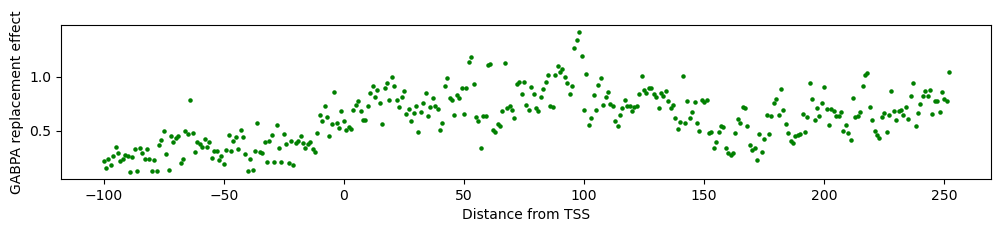

In [17]:
fig, ax = plt.subplots(figsize=(12,2))

#stem_plot = ax.stem(mean_effect['pos'], mean_effect['var_effect'], bottom=0, markerfmt=' ', basefmt=" ", linefmt='green')
ax.scatter(mean_effect['pos']-100, mean_effect['var_effect'], marker='o', s=5, color='green')
#for stemline in stem_plot:
#    stemline.set_linewidth(0.5)
ax.set_xlabel('Distance from TSS')
ax.set_ylabel('GABPA insertion effect')

In [260]:
!modisco motifs -s ohe.npz -a attr.npz -n 2000 -w 50 -o modisco_results.h5

(4, 50, 1)
50


In [261]:
file_path = 'modisco_results.h5'

with h5py.File(file_path, 'r') as file:
    # List all groups in the file
    print("Keys: %s" % file.keys())
    a_group_key = list(file.keys())[0]
    
    # Get the data from the first group
    data = list(file[a_group_key])
    
    # If you know the specific dataset you want, you can access it directly
    # dataset = file['dataset_name']
    # data = dataset[:]
    
    print(data)


Keys: <KeysViewHDF5 []>


IndexError: list index out of range

TypeError: string indices must be integers

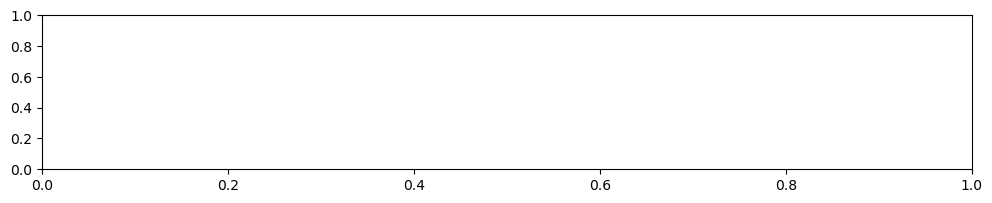

In [190]:
fig, ax = plt.subplots(figsize=(12,2))

logo_df = pivot_df.applymap(lambda x: 0)
original_seq = source_data[source_data['name'].str.contains('original')]['seq'][0]

var_means = []
for i, row in pivot_df.iterrows():
    base = original_seq[i]
    row.drop(original_seq[i])
    logo_df.loc[i, base] = row.sum()
    
crp_logo = logomaker.Logo(-1*logo_df,
                          shade_below=0.25,
                          fade_below=.5,
                          font_name='Arial Rounded MT Bold',
                          ax=ax)
